## 練習時間
參考 Day 12 範例程式，離散化你覺得有興趣的欄位，並嘗試找出有趣的訊息

In [2]:
# Import 需要的套件
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

### 之前做過的處理

In [3]:
# 設定 data_path
dir_data = './data/'
f_app_train = os.path.join(dir_data, 'application_train.csv')
f_app_test = os.path.join(dir_data, 'application_test.csv')

app_train = pd.read_csv(f_app_train)
app_test = pd.read_csv(f_app_test)

from sklearn.preprocessing import LabelEncoder

# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_train[col])
            # Transform both training and testing data
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

# Create an anomalous flag column
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
# also apply to testing dataset
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

# absolute the value of DAYS_BIRTH
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_test['DAYS_BIRTH'] = abs(app_test['DAYS_BIRTH'])

In [4]:
#先找出對應'TARGET'相關係數高的數據
corr_dist = {}
for col in app_train.columns:
    print(col, app_train[col].corr(app_train['TARGET']))
    corr_dist[col] = app_train[col].corr(app_train['TARGET'])

SK_ID_CURR -0.0021084690181977206
TARGET 1.0
NAME_CONTRACT_TYPE -0.0308959081610478
FLAG_OWN_CAR -0.021850938463835654
FLAG_OWN_REALTY -0.006148387704570299
CNT_CHILDREN 0.019187133596270115
AMT_INCOME_TOTAL -0.003981865601205655
AMT_CREDIT -0.030369286461429758
AMT_ANNUITY -0.012816561515413587
AMT_GOODS_PRICE -0.03964528116954427
REGION_POPULATION_RELATIVE -0.03722714854244533
DAYS_BIRTH -0.07823930830982709
DAYS_EMPLOYED 0.07495845742543839
DAYS_REGISTRATION 0.041974862831417235
DAYS_ID_PUBLISH 0.05145717260705741
OWN_CAR_AGE 0.0376115642751656
FLAG_MOBIL 0.0005343955790281198
FLAG_EMP_PHONE 0.045982219716592804
FLAG_WORK_PHONE 0.028524322363217308
FLAG_CONT_MOBILE 0.00037012680234897825
FLAG_PHONE -0.023806272330357335
FLAG_EMAIL -0.001758383431254637
CNT_FAM_MEMBERS 0.009307784396531136
REGION_RATING_CLIENT 0.05889901494571265
REGION_RATING_CLIENT_W_CITY 0.06089266756482348
HOUR_APPR_PROCESS_START -0.02416583143009439
REG_REGION_NOT_LIVE_REGION 0.0055759445209083635
REG_REGION_NOT

ORGANIZATION_TYPE_Industry: type 5 -0.001991675040093877
ORGANIZATION_TYPE_Industry: type 6 -0.0006516526920781005
ORGANIZATION_TYPE_Industry: type 7 -9.405271151196533e-05
ORGANIZATION_TYPE_Industry: type 8 0.0014357446973906644
ORGANIZATION_TYPE_Industry: type 9 -0.005378514581978444
ORGANIZATION_TYPE_Insurance -0.00384952351895412
ORGANIZATION_TYPE_Kindergarten -0.005764183870326947
ORGANIZATION_TYPE_Legal Services -0.00023598906873487606
ORGANIZATION_TYPE_Medicine -0.010618924847167466
ORGANIZATION_TYPE_Military -0.010057211128556483
ORGANIZATION_TYPE_Mobile 0.0012680907236234625
ORGANIZATION_TYPE_Other -0.003783785022873444
ORGANIZATION_TYPE_Police -0.009886470996787362
ORGANIZATION_TYPE_Postal 0.0011253764942944168
ORGANIZATION_TYPE_Realtor 0.003339079629980188
ORGANIZATION_TYPE_Religion -0.0013370635523446675
ORGANIZATION_TYPE_Restaurant 0.010265581100007071
ORGANIZATION_TYPE_School -0.013671152344879098
ORGANIZATION_TYPE_Security 0.007226072151375663
ORGANIZATION_TYPE_Security 

In [5]:
#先移除掉與自己最相關的'TARGET' 
corr_dist.pop('TARGET')

1.0

In [7]:
corr_max = max(corr_dist.keys(), key=(lambda k: corr_dist[k]))
corr_min = min(corr_dist.keys(), key=(lambda k: corr_dist[k]))
print('corr_max:', corr_max)
print('corr_min:', corr_min)


corr_max: DAYS_EMPLOYED
corr_min: EXT_SOURCE_3


In [24]:
#確認相關係數
print(corr_dist[corr_max])
app_train[corr_max].head()

0.07495845742543839


0    -637.0
1   -1188.0
2    -225.0
3   -3039.0
4   -3038.0
Name: DAYS_EMPLOYED, dtype: float64

In [9]:
corr_dist[corr_min]

-0.17891869762837076

In [27]:
#確認 DAYS_EMPLOYED 與 TARGET 的分佈
print("Correlation coeffect between DAYS_EMPLOYED and TARGET :", app_train[corr_max].corr(app_train['TARGET']))
(app_train[corr_max]/365).abs().describe()


Correlation coeffect between DAYS_EMPLOYED and TARGET : 0.07495845742543839


count    252137.000000
mean          6.531971
std           6.406466
min           0.000000
25%           2.101370
50%           4.515068
75%           8.698630
max          49.073973
Name: DAYS_EMPLOYED, dtype: float64

In [65]:
#申請貸款前工作的年份 min 0 , max 49, 每5年切一等份進行觀察
import warnings
warnings.filterwarnings('ignore')

years_of_job = app_train[['TARGET', 'DAYS_EMPLOYED']]
years_of_job['YEARS_EMPLOYED'] = (years_of_job.loc[:,'DAYS_EMPLOYED'] / 365).abs()

years_of_job['YEARS_OF_JOBS'] = pd.cut(years_of_job['YEARS_EMPLOYED'], bins = np.linspace(0, 50, num = 11))
years_of_job.head(10)

,TARGET,DAYS_EMPLOYED,YEARS_EMPLOYED,YEARS_OF_JOBS
0,1,-637.0,1.745205,"(0.0, 5.0]"
1,0,-1188.0,3.254795,"(0.0, 5.0]"
2,0,-225.0,0.616438,"(0.0, 5.0]"
3,0,-3039.0,8.326027,"(5.0, 10.0]"
4,0,-3038.0,8.323288,"(5.0, 10.0]"
5,0,-1588.0,4.350685,"(0.0, 5.0]"
6,0,-3130.0,8.575342,"(5.0, 10.0]"
7,0,-449.0,1.230137,"(0.0, 5.0]"
8,0,NaN,NaN,NaN
9,0,-2019.0,5.531507,"(5.0, 10.0]"


In [67]:
# Group by the bin and calculate averages
year_groups  = years_of_job.groupby('YEARS_OF_JOBS').mean()
year_groups

,TARGET,DAYS_EMPLOYED,YEARS_EMPLOYED
YEARS_OF_JOBS,,,
"(0.0, 5.0]",0.105708,-864.340763,2.368057
"(5.0, 10.0]",0.073714,-2630.224689,7.206095
"(10.0, 15.0]",0.057752,-4466.899670,12.238081
"(15.0, 20.0]",0.048484,-6306.860448,17.279070
"(20.0, 25.0]",0.047573,-8092.875701,22.172262
"(25.0, 30.0]",0.039903,-9961.437122,27.291609
"(30.0, 35.0]",0.041258,-11791.751418,32.306168
"(35.0, 40.0]",0.019231,-13517.634615,37.034615
"(40.0, 45.0]",0.004762,-15325.461905,41.987567


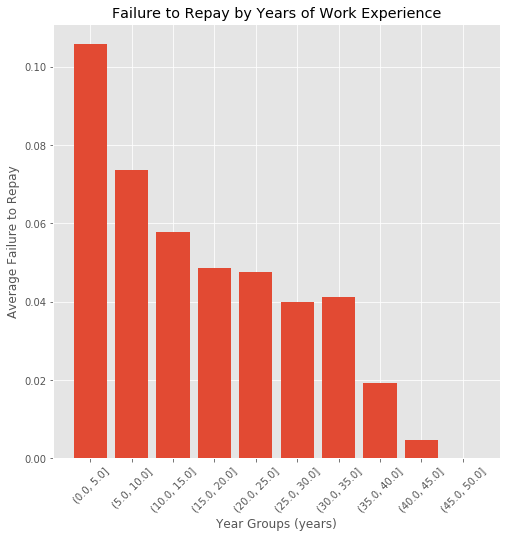

In [80]:
plt.style.use('ggplot')
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(range(len(year_groups.index)), year_groups['TARGET'])
# Plot labeling
plt.xticks(range(len(year_groups.index)), year_groups.index, rotation = 45); plt.xlabel('Year Groups (years)'); plt.ylabel('Average Failure to Repay')
plt.title('Failure to Repay by Years of Work Experience');

### 可看出工作年資少的違約遲繳的比例高於工作年資久的